
<img src="https://aiforall.azurewebsites.net/img/header2.png" width="75%"><br><br>
<h1> Estimating AI workers' prevalence : training and tuning a classifier </h1>

*v3.1, May 2019, Thomas Roca, PhD, Data Scientist, Microsoft & LinkedIn*

--- 

<br>
<h1>AI Profile Classifier with Scikit-Learn</h1>
<br>

The model was trained with relevant job descriptions advertized on linkedIn in 2018. "Synthetic profiles" were this way build, gathering job title, job description and skills associated. 

### LinkedIn learning introduction to Natural Language Processing:
- https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training/ 

### other resources
- http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
- https://www.datacamp.com/community/tutorials/scikit-learn-fake-news
- https://www.learndatasci.com/tutorials/predicting-reddit-news-sentiment-naive-bayes-text-classifiers/
- https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
- https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
- https://github.com/kjam/random_hackery/blob/master/Comparing%20Fake%20News%20Classifiers.ipynb
- https://blog.kjamistan.com/comparing-scikit-learn-text-classifiers-on-a-fake-news-dataset/ 
- https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
- https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

# Data Exploration

In [2]:
import pandas as pd
import re
df= pd.read_csv('data.csv', encoding='utf-8')
try: del df['Unnamed: 0']
except: pass
# Need to remove number from text
df['profile_content'] =df['profile_content'].str.replace('\d+', '') 
print(len(df))
df.head(10)

14287


,class,profile_content
0,Not_AI,urgent salesman wanted fast growing ai machine...
1,Not_AI,graduate it sales ai software includenew busin...
2,Not_AI,product manager machine learning platform make...
3,Not_AI,sales business development manager artificial ...
4,Not_AI,software product manager machine learning perk...
5,Not_AI,senior product manager bidding machine learnin...
6,Not_AI,csm customer success manager sales ai startup ...
7,Not_AI,Product Manager Artificial Intelligence why BN...
8,Not_AI,dos director sales artificial intelligence sta...
9,Not_AI,sales development representative ai martech st...


## Example of content

In [286]:
print(df['class'][0],'|', df['profile_content'][0])
print(df['class'][9331],'|', df['profile_content'][9331])

Not_AI | urgent salesman wanted fast growing ai machine learning tech company needs you focused sales person years sales usa starting real opportunity difference bonus ceos grit healthcare sales company research artificial intelligence ai machine learning
AI_profile | data scientist machine learning python art production quality machine learning models stealth automotive financial technology company equal opportunity employerall qualified applicants los angeles fair chance initiative los angeles qualified applicants real time production services offer free health benefits vision care coverage premiums offer flexible work hours develop machine learning models machine learning tech stack develop data products driven stack data sculptor molding raw data sets machine learning models machine learning algorithms offering unprecedented freedom fully digital experience entire app experience car acquisition process strong coding abilities earned trip word tolooking forward email subject line ni

# Class distribution

With 30% of Not_AI profiles in the training set we have a training set **a bit unbalanced**. We will need to be carefull while evaluating the models. Confusion Matrices are a good way to evaluate unbalanced misclassification (if the model tends to misclassify only in the direction of the unbalanced class)

**Ressources on umbalanced :**
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
- http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/applications/plot_topic_classication.html

Class: ['AI_profile', 'Not_AI']
Frequency: [69.90481522956327, 30.095184770436727]
Actuall Count: [9988, 4300] | Total: 14288


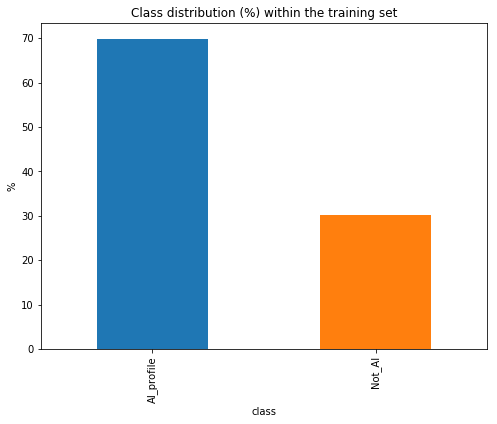

In [2]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
%matplotlib inline

number=df.groupby('class').profile_content.count()
percentage=number/number.sum()*100
fig = plt.figure(figsize=(8,6))
plt.ylabel('%')
plt.title('Class distribution (%) within the training set')
print("Class:", number.index.tolist())
print("Frequency:", percentage.tolist())
print("Actuall Count:", number.tolist(), "| Total:",number.sum())
percentage.plot.bar(ylim=0)
plt.show()

## Building the training and testing data

Here I use a 20/80 ratio for the testing set. By default the data are shuffled before splitting.
See more info on [Train_test_split in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [3]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

# Set `y` 
y = df['class']
# Drop the `label` column
df.drop("class", axis=1)
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(df['profile_content'], y, test_size=0.2, random_state=53)

## Vectorizing

Models do not understand words... In order to run models we need to transform text into numbers, extract variables (features) that characterize text input (member's information). Several technics exist to transform text into features. The process is called [features extraction](http://scikit-learn.org/stable/modules/feature_extraction.html). Common features extraction technics consist in counting (CountVectorizer aka [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model)) unique words or counting words next to each other([N-gram](https://en.wikipedia.org/wiki/N-gram)). It is also possible to count the frequency of words (terms frequency inverse document frequency - [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)), the amount of punctuation, capitalized letters, lenght of the text (e.g, use case: spam detection).

**More resources:**
- https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/ch04.html
- https://skymind.ai/wiki/bagofwords-tf-idf
- https://machinelearningmastery.com/gentle-introduction-bag-words-model/


Since computers do not understand the meaning of words (i.e. they just see them as characters), capital letters, punctuation, spaces, etc. do matter. To limit noise and allow models perform better, they must be fed with the most meanginful information.
Technics have been developped to simplify texts while keeping their meaning similar by removing certain words which are not adding significant meaning (e.g. [stopwords](https://en.wikipedia.org/wiki/Stop_words)), or by shortening (litteraly chopping) words by getting to their roots ([stemming](https://en.wikipedia.org/wiki/Stemming)) or to limit their diversity by grouping them according to their basic meaning - i.e. Lema- ([lemmatizing](https://en.wikipedia.org/wiki/Lemmatisation)). These technics do not appear patricularly usefull in our case as job title and skills are more similar to keywords. We only resort to extracting keywords and removing stopwords from job/ position description.

**More resources:**
- **From linkeding learning**:
    - https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training/introducing-stemming
    - https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training/introducing-lemmatizing
    - https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training/introducing-vectorizing
- https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
- http://scikit-learn.org/stable/modules/feature_extraction.html


Now that we have a training and a testing dataset, we can build the classifier. To get a good idea if the words and tokens in the profiles had a significant impact on whether the profile was AI or not_AI, lets's start by using CountVectorizer and TfidfVectorizer.

Another vectorizer used sometimes for text classification is a HashingVectorizer. Vectorizers require less memory and are faster (because they are sparse and use hashes rather than tokens) but are more difficult to introspect. See below more information aboutHashingVectorizer in the scikit-learn doc

More resources about hash vectorization:
- http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html
- https://kite.com/python/docs/sklearn.feature_extraction.text.HashingVectorizer


**1. Bags-of_words model**

**The question of Ngram...**
Using Ngram will let the model look into not only occurence of words but also occurences of word association. That could help classification, but also increase the number of features. 
Note that since words like "machine learning" and "deep learning", etc. are to build the training set, for both AI and Non_AI classes, those will note have any discrimination power.

Overall after trying N-Gramms on SVM it improved marginally the classification (1 observation misclassified was then well classified) Since the model performed already well, should we increase the number of features, the risk of overfitting is already high and I want the model to be able to generalize as much as possible considering the nature of the training set

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#personalized stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(["âº","institute","honors","technology","Show more","Field Of Study", "attended","or","expected","graduation","Name","study","indian","chinese","applied","english","graduation","tsinghua","studyeconomics","dates","field","study",'ê½cry', 'ð¹', 'ð¹ñ', 'ðºð', 'ð¼ñ', 'ð½ð³ð', 'ð½ñ''__mref', '_p', 'aa', 'aaa', 'aas', 'ab', "\n","Education","Degree","Name","Field", "Of","Study","â","Dates","attended","or","expected","graduation", "â€“", "Show","more", "Grade","( )","This","position","has","media"])

# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words=my_stop_words) #, ngram_range=(1, 2)) 
# question.. should i use N grams? this would increase the number of features for little gain

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 
# Transform the test set 
count_test = count_vectorizer.transform(X_test)

**2.Term Frequency–inverse Document Frequency**

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text

# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer =TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1, 1), max_df=0.7)
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

## Models comparisons

A quick way to check models accuracy is to draw confusion Matrices

In [12]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np 
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Lets start with the usual suspect a Naive Bayes classifiers

accuracy:   0.985
Confusion matrix, without normalization


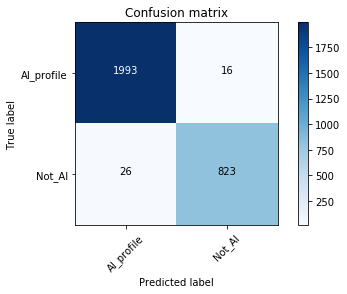

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf = MultinomialNB(alpha=0.05) 
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['AI_profile', 'Not_AI'])
plot_confusion_matrix(cm, classes=['AI_profile', 'Not_AI'])

## Bags of Words implementation

More info about Bag-of-words (aka CountVectorizer): https://en.wikipedia.org/wiki/Bag-of-words_model

accuracy:   0.977
Confusion matrix, without normalization


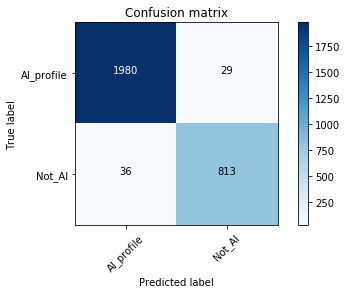

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf = MultinomialNB(alpha=0.05)
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['AI_profile', 'Not_AI'])
plot_confusion_matrix(cm, classes=['AI_profile', 'Not_AI'])

**First observations:**
With no parameter tuning, count vectorized training set count_train provides the same performance as a TF-IDF vectors.
Lets fine tune a bit playing with Alpha

**NB. In general it is better to use the AUC than accuracy as target for fine tuning.. Problem: SVM is a discreet classifier and ROC curve would actually not be a curve and the approach is less straight forward with this kind of classifier**

**Fine tuning: alpha - additional smoothing parameter**

In [29]:
last_score = 0
for alpha in np.arange(0,1,.001):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(count_train, y_train)
    pred = nb_classifier.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
        print("Alpha: {:.5f} Score: {:.5f}".format(alpha, score))
        last_score=score

C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.00000 Score: 0.98635


In [30]:
last_score = 0
for alpha in np.arange(0,1,.001):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
        print("Alpha: {:.5f} Score: {:.5f}".format(alpha, score))
        last_score=score

C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.00000 Score: 0.98810


### Conclusion:
Multinomial Naive Bayes Classifier gets its best performance with TF-IDF vectors and alpha=0.000. It predicts accurately AI from non_AI profiles in 98.8% of cases in the testing set. As shown by the confusion matrix below, 6 Not_AI profiles were tagged as AI and 28 AI_profiles were labelled as not_AI. 2824 Profiles were correctly identified.

C:\Python35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


accuracy:  0.988
Confusion matrix, without normalization


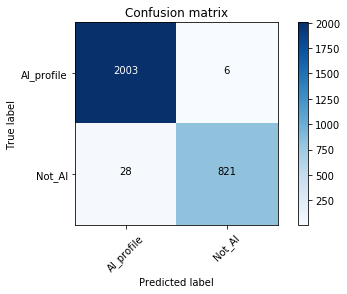

In [25]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0) 
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)

print("accuracy:  %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['AI_profile', 'Not_AI'])
plot_confusion_matrix(cm, classes=['AI_profile', 'Not_AI'])

## Testing logistic regression

Logistic Regression
accuracy:  0.992
Confusion matrix, without normalization


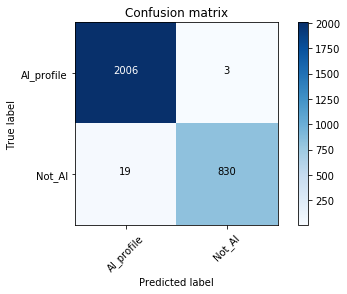

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

clf =LogisticRegression()
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)

print("Logistic Regression")
print("accuracy:  %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['AI_profile', 'Not_AI'])
plot_confusion_matrix(cm, classes=['AI_profile', 'Not_AI'])

## with Bags of words

Logistic Regression
accuracy:  0.997
Confusion matrix, without normalization


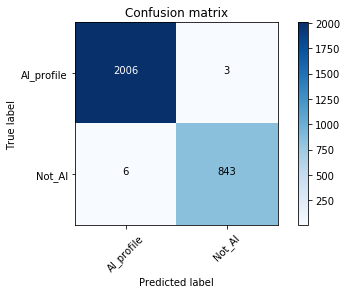

In [26]:
clf =LogisticRegression()
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)

print("Logistic Regression")
print("accuracy:  %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['AI_profile', 'Not_AI'])
plot_confusion_matrix(cm, classes=['AI_profile', 'Not_AI'])

# Testing Linear SVM Models


**Some references:**

- Support Vector Machine doc on scikit: http://scikit-learn.org/stable/modules/svm.html
- Pretty detailed also on wikipedia: https://en.wikipedia.org/wiki/Support_vector_machine


ROC:
No ROC possible with SVM but
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

### Linear Support Vector Machine with TFIDF

Running Time: confusion matrix started at: 06:12:16 04/24/19
Running Time: ended at: 06:14:07 04/24/19
accuracy:   0.996
Confusion matrix, without normalization


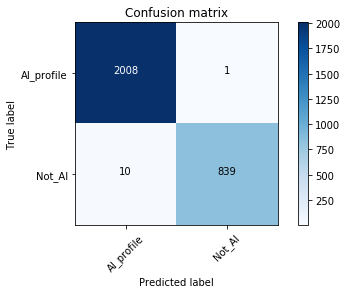

In [18]:
from sklearn.svm import SVC
import time
print('Running Time: confusion matrix started at:',time.strftime('%X %x'))
clf = SVC(probability=True, kernel='linear')
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
cm = metrics.confusion_matrix(y_test, pred, labels=['AI_profile', 'Not_AI'])
print('Running Time: ended at:',time.strftime('%X %x'))
print("accuracy:   %0.3f" % score)
plot_confusion_matrix(cm, classes=['AI_profile', 'Not_AI'])

### Linear Support Vector Machine with bags of words model

Running Time: confusion matrix started at: 06:19:21 04/24/19
Running Time: ended at: 06:20:09 04/24/19
accuracy:   0.997
Confusion matrix, without normalization


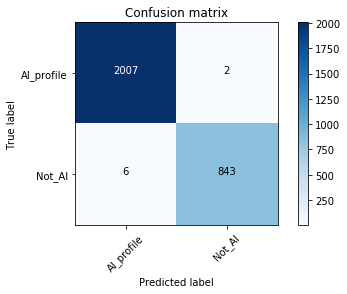

In [27]:
from sklearn.svm import SVC
import time
from sklearn import metrics
print('Running Time: confusion matrix started at:',time.strftime('%X %x'))
clf = SVC(probability=True, kernel='linear')
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
cm = metrics.confusion_matrix(y_test, pred, labels=['AI_profile', 'Not_AI'])

print('Running Time: ended at:',time.strftime('%X %x'))
print("accuracy:   %0.3f" % score)
plot_confusion_matrix(cm, classes=['AI_profile', 'Not_AI'])

# Other metric and discussion 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test,pred))  
print(accuracy_score(y_test, pred))  

             precision    recall  f1-score   support

 AI_profile       1.00      1.00      1.00      2009
     Not_AI       1.00      0.99      1.00       849

avg / total       1.00      1.00      1.00      2858

0.9972008397480756


--- 

# Features analysis

To inspect our features we can print the most informative ones and check if the variable the more at play for separating the two classes make sens..

In [9]:
from sklearn.svm import LinearSVC
from sklearn import metrics
svc_tfidf_clf = LinearSVC()
svc_tfidf_clf.fit(tfidf_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [12]:
# use python 3.5 or less for this.. error in handeling the dict with python 3.6
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=45):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    return {class_labels[0]: topn_class1,
            class_labels[1]: topn_class2
    }

most_informative_feature_for_binary_classification(tfidf_vectorizer, svc_tfidf_clf, n=45)

{'AI_profile': [(-1.9145354000261754, 'engineer'),
  (-1.65012964872895, 'scientist'),
  (-1.5059137317929978, 'engineers'),
  (-1.2598064012245551, 'research'),
  (-1.1803831238455333, 'python'),
  (-0.9747670983992747, 'delivery'),
  (-0.9723389089083536, 'engineering'),
  (-0.9036139669905278, 'statistics'),
  (-0.8730507835907059, 'systems'),
  (-0.8688796229388313, 'design'),
  (-0.8328123293813997, 'development'),
  (-0.8027224129423047, 'java'),
  (-0.7835691947848882, 'yoshimura'),
  (-0.7792597148709864, 'test'),
  (-0.7459026542595943, 'programming'),
  (-0.7394696598220916, 'techniques'),
  (-0.7077059333859712, 'researcher'),
  (-0.7034329833775941, 'deep'),
  (-0.6673393142485441, 'algorithms'),
  (-0.6509524858806823, 'scalability'),
  (-0.6307620737917745, 'computer'),
  (-0.6009065246789608, 'health'),
  (-0.576876886167871, 'inference'),
  (-0.564272508086367, 'statistical'),
  (-0.5620539904957711, 'softwareziprecruiter'),
  (-0.5545876143782019, 'bayesian'),
  (-0.54

## Inspecting the features

All that makes sens, but the names of two companies (Yoshimura & softwareziprecruiter) appearing so high in the top informative feature is worth investgating

In [13]:
yoshi=df[df['profile_content'].str.contains("yoshimura")]
print(len(yoshi))
yoshi

22


,class,profile_content
4380,AI_profile,vp product engineering machine learning produc...
4448,AI_profile,vp product engineering machine learning produc...
4678,AI_profile,vp product engineering machine learning produc...
5344,AI_profile,data scientist artificial intelligence predict...
5673,AI_profile,vp product engineering machine learning produc...
6586,AI_profile,vp product engineering machine learning produc...
6686,AI_profile,vp product engineering machine learning produc...
6781,AI_profile,data scientist artificial intelligence predict...
6896,AI_profile,data scientist artificial intelligence predict...
7315,AI_profile,data scientist artificial intelligence predict...


Overall Yoshimura appear in 22 entries (see below) while Softwareziprecruiter appears in 6 entries.These entries seems legit and does correspond to an AI profile.


In [14]:
for entry in yoshi.index.tolist():
    print(yoshi['profile_content'][entry])

vp product engineering machine learning product scalability end end proprietary platform equal opportunity employerall qualified applicants  person funded startup tackle electrical measurements scale asaptop reasons competitive pay k word tolooking forward email subject line vp product engineering  engineers product scalabilitywhat protected veteran status industrial iot experience product scalability characteristic protected machine learning gas companies apply today clicking apply colby yoshimura executive recruiter receive consideration national origin federal law persons hired verify identity united states yoshimura cybercoders experience cybercoders positionmore kb  application considered cybercodersapplicants authorized employment disability compliance eligibility ruby rails market research mobile technology medical devices perl cloud computing design experiments paas agile methodologies product strategy embedded systems talent management virtualization semiconductors direct sale

In [15]:
soft=df[df['profile_content'].str.contains("softwareziprecruiter")]
print(len(soft))
soft

6


,class,profile_content
4845,AI_profile,senior machine learning engineer single core ...
5186,AI_profile,senior machine learning engineer single core ...
6225,AI_profile,senior machine learning engineer single core ...
6869,AI_profile,senior machine learning engineer single core ...
11971,AI_profile,senior machine learning engineer single core ...
13208,AI_profile,senior machine learning engineer single core ...


In [16]:
soft['profile_content'][4845]

'senior machine learning engineer single  core gb ram machine pre fab csv data set open flexible vacation policy ziprecruiter build simple systems quickly fastest growing employment marketplace award winning mobile apps active job seekers interacting billion historical job postings  million job seekers machine learning technique consistently low latency unexpected missing inputs involve large matrices space time requirements great exploratory tool internal  bit limits helping literally millions equal opportunity employer curated email alerts data driven features processgathering training data huge scale search training set job postings open pixels machine resources usebig data million businesses people job posting job application job opening job seeker youknowing job boards extracting features search algorithm role summaryit jupyter notebook easily fits multiple machines makes predictions click events incredible opportunities recommendation predicts salaries candidate matching python c

**Conclusion:**
To avoid having such a weight comming from features that my be misleading we decide to suppress from the trainin set, the actual words in the entries. We did the same with the following words: 'radiance', 'salem', 'good', 'sonuma', 'characterize', 'french', 'pinterest'

In [13]:
exclude_list=['softwareziprecruiter','yoshimura','radiance', 'salem', 'good', 'sonuma', 'characterize', 'french', 'pinterest']
for item_to_exclude in exclude_list:
    df['profile_content'].replace(item_to_exclude,'',regex=True,inplace=True)

### Updating the model
with this small update in the training set we need to retrain the model

In [5]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
from sklearn.svm import LinearSVC
from sklearn import metrics

# Set `y` 
y = df['class']
# Drop the `label` column
df.drop("class", axis=1)
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(df['profile_content'], y, test_size=0.2, random_state=53)

# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer =TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1, 1), max_df=0.7)
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

# ------ train -----
svc_tfidf_clf = LinearSVC()
svc_tfidf_clf.fit(tfidf_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### Checking if the most informative features updated

https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

Once a linear SVM is fit to data (e.g., svm.fit(features, labels)), the coefficients can be accessed with svm.coef_. Recall that a linear SVM creates a hyperplane that uses support vectors to maximise the distance between the two classes. The weights obtained from svm.coef_ represent the vector coordinates which are orthogonal to the hyperplane and their direction indicates the predicted class. The absolute size of the coefficients in relation to each other can then be used to determine feature importance for the data separation task.

In [6]:
# use python 3.5 or less for this.. error in handeling the dict with python 3.6
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=40):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    return {class_labels[0]: topn_class1, 
            class_labels[1]: topn_class2,
            }

most_informative_feature_for_binary_classification(tfidf_vectorizer, svc_tfidf_clf, n=30)

{'AI_profile': [(-2.040436501330393, 'engineer'),
  (-1.7840052936227566, 'engineers'),
  (-1.6562691839356307, 'scientist'),
  (-1.440576535069794, 'research'),
  (-1.1332801846082936, 'python'),
  (-1.0849360741007148, 'java'),
  (-0.9835003953697924, 'engineering'),
  (-0.9017744050850572, 'systems'),
  (-0.8668984544091197, 'development'),
  (-0.8597189019608863, 'design'),
  (-0.8470757050867711, 'statistics'),
  (-0.8425350641012777, 'programming'),
  (-0.795390924320328, 'yoshimura'),
  (-0.7571832176729787, 'algorithms'),
  (-0.6913172937586078, 'techniques'),
  (-0.6880979107661352, 'distributed'),
  (-0.6742897002471494, 'researcher'),
  (-0.6738902653384226, 'search'),
  (-0.6688440798270298, 'deep'),
  (-0.6677020436694737, 'statistical'),
  (-0.6661228529287317, 'test'),
  (-0.6651032960644023, 'softwareziprecruiter'),
  (-0.652054392631685, 'hadoop'),
  (-0.5906665999902414, 'scalability'),
  (-0.5884084607984581, 'writing'),
  (-0.5822736106834204, 'supervised'),
  (-0.5

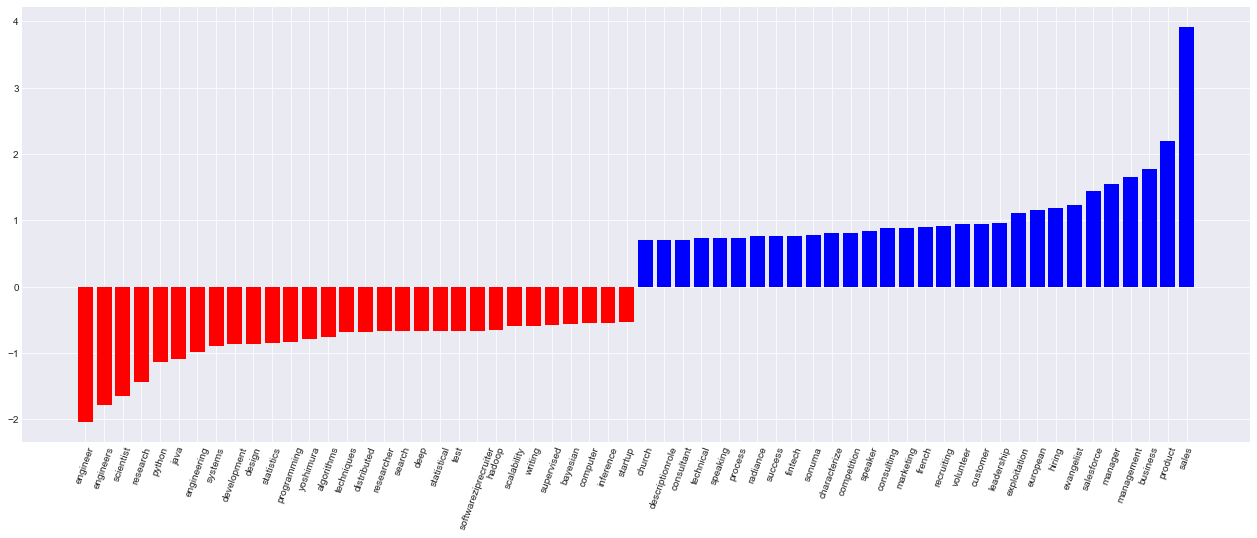

In [8]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
plt.style.use('seaborn-darkgrid')
#print(plt.style.available)
number=30
dict_inform=most_informative_feature_for_binary_classification(tfidf_vectorizer, svc_tfidf_clf, n=number)
s=dict_inform['AI_profile']
df_AI=pd.DataFrame(list(s))
df_AI.columns=['score','feature']
df_AI=df_AI.set_index('feature')

df_Not_AI=pd.DataFrame(list(dict_inform['Not_AI']))
df_Not_AI.columns=['score','feature']
df_Not_AI=df_Not_AI.set_index('feature')
df_AI=df_AI.append(df_Not_AI)

from matplotlib.pyplot import figure
figure(figsize=(22, 8))
plt.xticks(rotation=70)

plt.bar(df_AI[0:number].index.values,df_AI['score'][0:number], color='r')
plt.bar(df_AI[number:number*2].index.values,df_AI['score'][number:number*2], color='b')
plt.savefig('informative_features.png',bbox_inches='tight', dpi=400)
plt.show()

### Conclusion

So far the best implementation we have is with a count_vectorizer and a Support Vector Machine.
Before saving drawing conclusion let's check for cross validation (randomly selecting alternative training/testing sample) with 5 iterations. Will will benchmark a few other models to be sure..

---

# Benchmarking and cross validated models with bags-of-words model

In [73]:
import pandas as pd
import time
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction import text

#personalized stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(["âº","institute","honors","technology","Show more","Field Of Study", "attended","or","expected","graduation","Name","study","indian","chinese","applied","english","graduation","tsinghua","studyeconomics","dates","field","study",'ê½cry', 'ð¹', 'ð¹ñ', 'ðºð', 'ð¼ñ', 'ð½ð³ð', 'ð½ñ''__mref', '_p', 'aa', 'aaa', 'aas', 'ab', "\n","Education","Degree","Name","Field", "Of","Study","â","Dates","attended","or","expected","graduation", "â€“", "Show","more", "Grade","( )","This","position","has","media"])

# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words=my_stop_words)
features =count_vectorizer.fit_transform(df['profile_content']).toarray()
labels = df["class"]
features.shape

print('Processing started at:',time.strftime('%X %x'))

models = [
    RandomForestClassifier(n_estimators=300, max_depth=3, random_state=0),
    #SVC(probability=True, kernel='linear'),
    LogisticRegression(C=0.01),
    SVC(kernel='linear'),
    MultinomialNB(alpha=0.008),
    KNeighborsClassifier(n_neighbors=10),
    NearestCentroid(),
    BernoulliNB(alpha=.01)
]

CV = 5
#CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df_count_vectorizer= pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

print('Processing ended at:',time.strftime('%X %x'))

Processing started at: 22:38:44 04/03/19
Processing ended at: 00:22:46 04/04/19


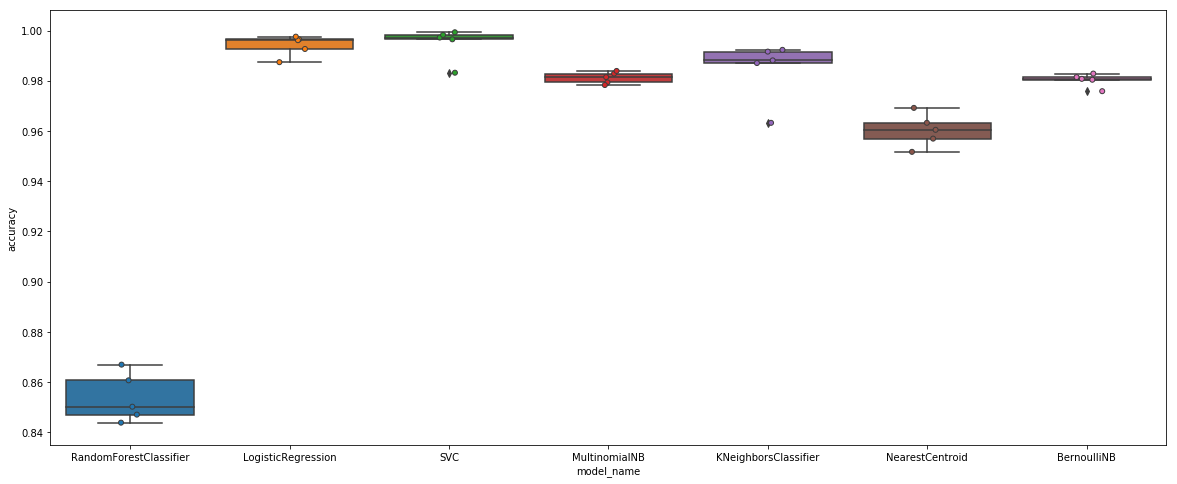

In [79]:
#%matplotlib inline
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df_count_vectorizer)
sns.stripplot(x='model_name', y='accuracy', data=cv_df_count_vectorizer, 
             jitter=True, edgecolor="gray", linewidth=1)

#cv_df_count_vectorizer.groupby('model_name').accuracy.mean().reset_index().set_index('model_name')
plt.show()

## Pick the best model and save it with pickle

In our previous test SVM outperformed Logistic regression.When choosing models, there are tradeoffs.. Although HashingVectorizer slightly outperforms bags-of-words model for SVC, I choose to go with Hash vectorizer for explainability purposes (it is not possible to explain the most influencial features).For the same reason, although I explore Deep Learning (Multi-layer Perceptron) with TensorFlow with very similar results. I decided to go with the Support Vector Machine as contrarily to Logistic regression skicit learn implementation of SVM allows to display probablity, we will use this feature when predicting the class.

**Conclusion:** [Support Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine) with bags-of-word model for features extraction. NB. I chose SVC(probability=True, kernel='linear') over LinearSVC(). Both are linear SVM but SVC allows for displaying probability. For difference between LinearSVC() and SVC(kernel='linear') see: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC 

More info on SVM in Scikit_learn: http://scikit-learn.org/stable/modules/svm.html

# Bags of words

In [15]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
import time
from sklearn.svm import SVC

clf = SVC(probability=True, kernel='linear')

#personalized stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(["âº","institute","honors","technology","Show more","Field Of Study", "attended","or","expected","graduation","Name","study","indian","chinese","applied","english","graduation","tsinghua","studyeconomics","dates","field","study",'ê½cry', 'ð¹', 'ð¹ñ', 'ðºð', 'ð¼ñ', 'ð½ð³ð', 'ð½ñ''__mref', '_p', 'aa', 'aaa', 'aas', 'ab', "\n","Education","Degree","Name","Field", "Of","Study","â","Dates","attended","or","expected","graduation", "â€“", "Show","more", "Grade","( )","This","position","has","media"])

# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words=my_stop_words)
# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 
# Transform the test set 
count_test = count_vectorizer.transform(X_test)
clf.fit(count_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Running Time: ended at: 10:56:44 06/06/19
accuracy:   0.998
Confusion matrix, without normalization


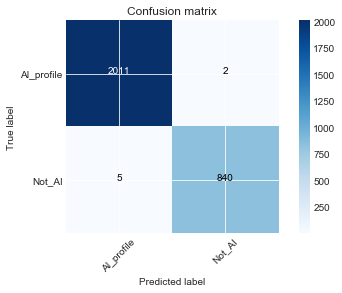

In [16]:
import time
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
cm = metrics.confusion_matrix(y_test, pred, labels=['AI_profile', 'Not_AI'])
print('Running Time: ended at:',time.strftime('%X %x'))
print("accuracy:   %0.3f" % score)
plot_confusion_matrix(cm, classes=['AI_profile', 'Not_AI'])

# Hyper parameters tuning

When fitting a Support Vector Machine classifier, two hyper-parameters are considered important: the Kernel trick and the Penalty parameter C of the error term. The first allows to specify whether data are linearly separable and the second allows fine-tuning how closely the classifier fits to the training data.
To fine-tunes those two parameters I used GridSearchCV
Parameters description for SVC in scikit: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
For SVC and linear kernel, C parameter is enough for fine tuning. When using non linear kernel, Gama can be fine tuned as well

In [18]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

def print_results(results):
    print("Best Params:{}\n".format(results.best_params_))
    means=results.cv_results_['mean_test_score']
    stds=results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean,3), round(std * 2,3),params))

svc=SVC()

parameters = {
 'kernel' : ['linear', 'rbf'],
 'C' :[0.1,1,10],
 'gamma':[0.1,1,10]
}

cv = GridSearchCV(svc, parameters, cv=5)
cv.fit(count_train, y_train)


print_results(cv)
print("\nBest estimator:")
print(cv.best_estimator_)

Best Params:{'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}

0.996 (+/-0.0) for {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}
0.812 (+/-0.006) for {'kernel': 'rbf', 'gamma': 0.1, 'C': 0.1}
0.996 (+/-0.0) for {'kernel': 'linear', 'gamma': 1, 'C': 0.1}
0.792 (+/-0.005) for {'kernel': 'rbf', 'gamma': 1, 'C': 0.1}
0.996 (+/-0.0) for {'kernel': 'linear', 'gamma': 10, 'C': 0.1}
0.791 (+/-0.004) for {'kernel': 'rbf', 'gamma': 10, 'C': 0.1}
0.996 (+/-0.0) for {'kernel': 'linear', 'gamma': 0.1, 'C': 1}
0.925 (+/-0.004) for {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
0.996 (+/-0.0) for {'kernel': 'linear', 'gamma': 1, 'C': 1}
0.909 (+/-0.006) for {'kernel': 'rbf', 'gamma': 1, 'C': 1}
0.996 (+/-0.0) for {'kernel': 'linear', 'gamma': 10, 'C': 1}
0.908 (+/-0.007) for {'kernel': 'rbf', 'gamma': 10, 'C': 1}
0.996 (+/-0.0) for {'kernel': 'linear', 'gamma': 0.1, 'C': 10}
0.932 (+/-0.006) for {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
0.996 (+/-0.0) for {'kernel': 'linear', 'gamma': 1, 'C': 10}
0.911 (+/-0.007) f

## Conclusion

The outcome shows that the C parameters had little influence on the results and that the data are linearly separable.
As a result, I kept the default value for the C parameters and used the linear kernel (Gamma parameter not applicable).
I thus made no changes to the previous specifications of the classifier.

*NB. the results can be diffrent from the results showed by the confusion matrix has it operates on several sample like in Cross validation see parameter cv = 5 in GridSearchCV()*

*NB. GridSearch took + 5 hours computation*

# Save the model 

In [10]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
model=clf
filename=('models/trained_model_scikitV3_BagOfWord.sav')
filename_vect=('models/vectorizerV3_BagOfWord.pk')

pickle.dump(count_vectorizer, open(filename_vect, 'wb'))
pickle.dump(model, open(filename, 'wb'))

--- 